# Part 3. Extracting signal from a region of interest

In Part 1, we preprocessed the data (or, at least, explored *how* you could go about preprocessing your data). Let's just use the `fmriprep`-preprocessed data for the remainder of the tutorial. Here, we will extract signal from a region of interest: striatum. Striatum is part of the Basal Ganglia, and has repeatedly been implicated in response caution adjustments (e.g., [Forstmann et al 2008](http://www.pnas.org/content/105/45/17538/#F2); [Van Maanen et al 2011](http://www.jneurosci.org/content/31/48/17488)). In Part 3 and 4 of this tutorial, we'll see if we can replicate this result.

In order to extract signal from a region of interest, we need a mask that tells us where this ROI lies in the brain. Since `fmriprep` registered ('normalized') our data to MNI152-space, we can use a mask from an atlas in MNI152-space.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nipype.interfaces import fsl
import nilearn.datasets

%matplotlib inline

## A look at masks

In the directory `/data/masks/` you can find various masks, including one for the left and one for the right striatum

In [2]:
!ls /data/masks/MNI152-2mm

GPe_L.nii.gz  GPi_L.nii.gz  STR_L.nii.gz
GPe_R.nii.gz  GPi_R.nii.gz  STR_R.nii.gz


Let's load a mask and see what it looks like.

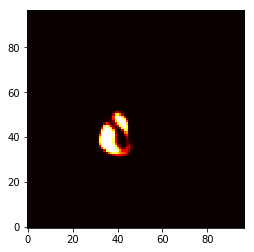

In [3]:
str_l = nib.load('/data/masks/MNI152-2mm/STR_L.nii.gz').get_data()
plt.imshow(str_l[:, 68, :].T, origin='lower', cmap=plt.cm.hot)

Note that this is a *probabilistic* map. The colors in the above plot indicate the *probability* for each voxel that is is part of any given individual's left striatum. Further, probabilities of 0 lead to a black pixel in the plot above.

Let's mask all voxels that have a probability of 50% or less of belonging to any of the striatal parts. This way, they won't end up as black pixels when we plot them, but become transparant

In [4]:
str_l = np.ma.masked_less(str_l, 0.5)

Now, `str_l` is a 3D-matrix indicating for each voxel the probability that it belongs to the left striatum. What does this look like?

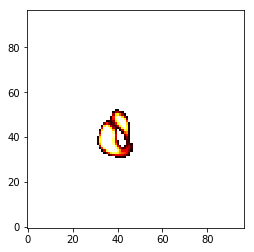

In [5]:
plt.imshow(str_l[:, 68, :].T, origin='lower', cmap=plt.cm.hot)

The background is now white instead of black, which doesn't help much. But now we can superimpose this mask on an MNI152 template

In [6]:
# Load the MNI template
mni = nib.load('/data/mni_icbm152_nlin_asym_09c/2mm_T1.nii.gz').get_data()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


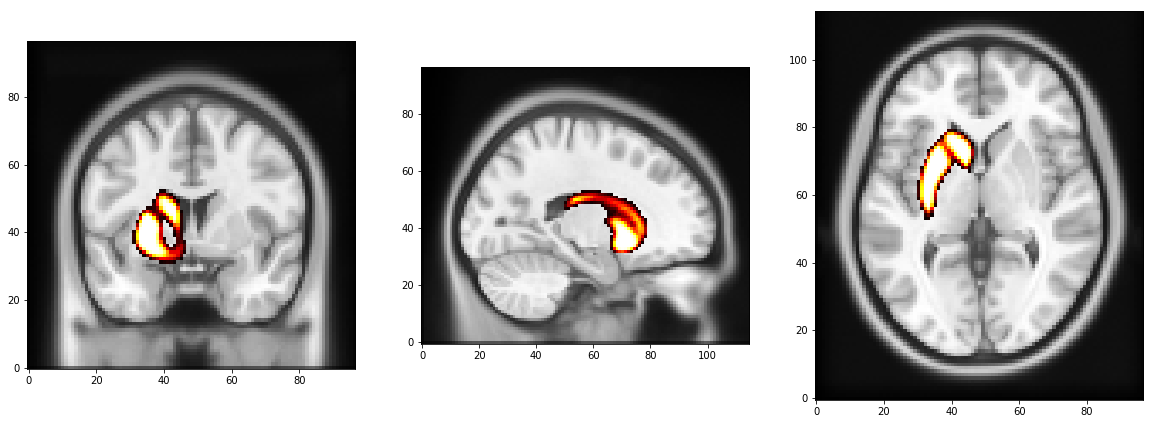

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mni[:, 68, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, 68, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(132)
plt.imshow(mni[38, :, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[38, :, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(133)
plt.imshow(mni[:, :, 40].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, :, 40].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

And that's where left striatum is located probabilistically

Note that the `str_l` variable is a kind of image. You can apply image processing tools to it; for example, to find the center of mass (this is how the slices plotting above were chosen)

In [8]:
import scipy as sp
from scipy import ndimage
com = ndimage.center_of_mass(str_l)
com

(38.033724345230205, 68.37897524999154, 40.79747029165641)

1) Can you make the same plots for right striatum? Find the center of mass, and plot it on an MNI152-brain

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


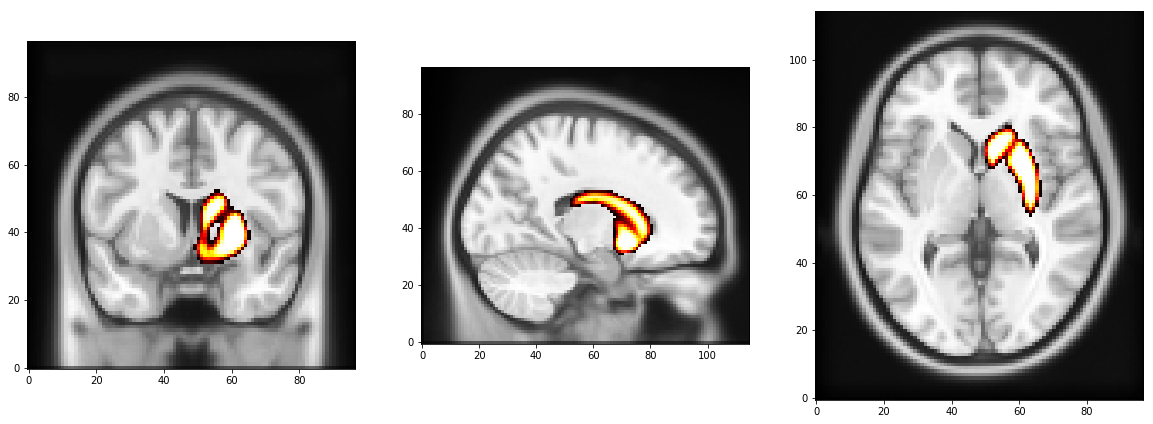

In [9]:
str_r = nib.load('/data/masks/MNI152-2mm/STR_R.nii.gz').get_data()
str_r = np.ma.masked_less(str_r, 0.5)
com = ndimage.center_of_mass(str_r)

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mni[:, int(com[1]), :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_r[:, int(com[1]), :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(132)
plt.imshow(mni[int(com[0]), :, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_r[int(com[0]), :, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(133)
plt.imshow(mni[:, :, int(com[2])].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_r[:, :, int(com[2])].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

## Extracting signal from a masked region
Back to Nipype. Nipype contains interfaces that allows you to extract a time series *meaned* over a region of interest. The interface is called `ImageMeants()`. Let's first see how this works

In [10]:
# We'll need these libraries below
from nipype.interfaces import fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio

In [11]:
!ls /data/deriv/fmriprep/sub-483/func

sub-483_task-SAT_run-1_desc-confounds_regressors.json
sub-483_task-SAT_run-1_desc-confounds_regressors.tsv
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-aparcaseg_dseg.nii.gz
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json
sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-483_task-SAT_run-2_desc-confounds_regressors.json
sub-483_task-SAT_run-2_desc-confounds_regressors.tsv
sub-483_task-SAT_run-2_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-483_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-aparcaseg_dseg.nii.gz
sub-483_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz
sub-483_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-48

In [12]:
extracter = fsl.ImageMeants()
extracter.inputs.in_file = '/data/deriv/fmriprep/sub-483/func/sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
extracter.inputs.mask = '/data/masks/MNI152-epi/STR_L.nii.gz'

In [13]:
r = extracter.run()
r.outputs


out_file = /home/neuro/nipype_tutorial/sub-483_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt

Now, using `np.loadtxt(<path_to_txt_file>)`, you can load the output. 

2) Can you plot the data?

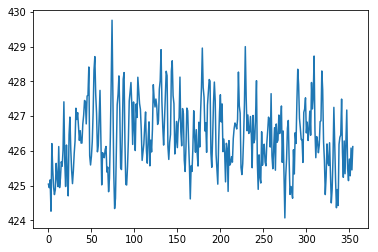

In [14]:
raw_str_data = np.loadtxt(r.outputs.out_file)   # here we load
plt.plot(raw_str_data) # plot

## Making a pipeline
Now we semi-manually extracted a single subject's time series signal meaned over striatum. We could do this in the same way for all subjects, but it's much more efficient to make a pipeline. Let's make one that extracts the time series meaned over striatum for all participants. First, set-up the nodes we want to use

In [15]:
# This is the node that extracts signal
extracter = pe.MapNode(fsl.ImageMeants(), iterfield='in_file', name='extract_mean_ts')

Note that this is a [MapNode](https://pythonhosted.org/nipype/api/generated/nipype.pipeline.engine.nodes.html#mapnode) rather than a regular Node; i.e., a Node the receives a list of inputs and applies the same interface to each element of the list.

3) In the cell below, create/fill: 
- the template for where to find the masks
- the template for where to find the functional data (similar to Part 1)
- all subject ids at selector.iterator. 
- fill in the mask names at selector.iterator

In [16]:
# Here, we set-up a SelectFile-Node
templates = {
    'mask': '/data/masks/MNI152-epi/{mask}.nii.gz',  # NB: use folder "MNI152-epi" here instead of "MNI152-2mm"
    'func': '/data/deriv/fmriprep/sub-{subject_id}/func/sub-{subject_id}_task-SAT_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
}

selector = pe.Node(nio.SelectFiles(templates=templates), name='file_selector')
selector.iterables = [('subject_id', ['197', '372', '381', '471', '483', '498', '523', '544', '548', '549', '551', '552', '553', '554', '555', '558', '559']), 
                      ('mask', ['STR_L', 'STR_R'])]


# A datasink is useful for exporting. Remember the base_directory - this is where the data will be saved later
ds = pe.Node(nio.DataSink(base_directory='/data/extracted_signals'), 
             name='datasink')

Then, combine everything in a Workflow.

4) In the cell below, make the right connections in the workflow: you want to connect the `selector` to the `extractor` in two ways. Remember that you can call `fsl.ImageMeants.help()` to see the input argument names

190802-11:40:07,877 nipype.workflow INFO:
	 Generated workflow graph: /data/workflow_folders/extract_striatum_signal/graph.png (graph2use=hierarchical, simple_form=True).


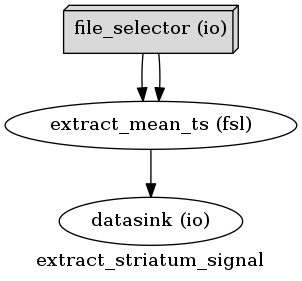

In [17]:
workflow = pe.Workflow(base_dir='/data/workflow_folders/', 
                       name='extract_striatum_signal')

# Connect the Nodes
workflow.connect(selector, 'mask', extracter, 'mask')
workflow.connect(selector, 'func', extracter, 'in_file')
workflow.connect(extracter, 'out_file', ds, 'extracted_timeseries')

# Make a graph to visualize what we did..
workflow.write_graph('graph.dot', format='png')
from IPython.display import Image
Image('/data/workflow_folders/extract_striatum_signal/graph.png')

And we're ready to run

In [18]:
workflow.run('MultiProc', plugin_args={'n_proc': 3})

190802-11:40:07,899 nipype.workflow INFO:
	 Workflow extract_striatum_signal settings: ['check', 'execution', 'logging', 'monitoring']
190802-11:40:08,28 nipype.workflow INFO:
	 Running in parallel.
190802-11:40:08,35 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 34 jobs ready. Free memory (GB): 338.90/338.90, Free processors: 32/32.
190802-11:40:08,373 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_558/file_selector".

190802-11:40:08,375 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_555/file_selector".190802-11:40:08,382 nipype.workflow INFO:
	 [Node] Running "file_selector" ("nipype.interfaces.io.SelectFiles")190802-11:40:08,379 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_sign

	 [Node] Running "file_selector" ("nipype.interfaces.io.SelectFiles")190802-11:40:08,429 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_523/file_selector".

190802-11:40:08,433 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal.file_selector".190802-11:40:08,434 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_523/file_selector".190802-11:40:08,435 nipype.workflow INFO:
	 [Node] Running "file_selector" ("nipype.interfaces.io.SelectFiles")
190802-11:40:08,434 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal.file_selector".


190802-11:40:08,438 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal.file_selector".
190802-11:40:08,440 nipype.workflow INFO:
	 [Node] Running "file_selector" ("nipype.interfaces.io.SelectFiles")
190802-11:4

190802-11:40:10,97 nipype.workflow INFO:
	 [Job 87] Completed (extract_striatum_signal.file_selector).
190802-11:40:10,98 nipype.workflow INFO:
	 [Job 90] Completed (extract_striatum_signal.file_selector).
190802-11:40:10,99 nipype.workflow INFO:
	 [Job 93] Completed (extract_striatum_signal.file_selector).
190802-11:40:10,101 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 34 jobs ready. Free memory (GB): 338.90/338.90, Free processors: 32/32.
190802-11:40:10,371 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_197/file_selector".190802-11:40:10,373 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.file_selector" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_197/file_selector".

190802-11:40:10,380 nipype.workflow INFO:
	 [Node] Running "file_selector" ("nipype.interfaces.io.SelectFiles")190802-11:40:10,381 nipype.workflow INF

	 [Node] Finished "extract_striatum_signal.datasink".190802-11:40:16,123 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_558/datasink".
190802-11:40:16,125 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

190802-11:40:16,127 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")190802-11:40:16,127 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_555/datasink".

190802-11:40:16,131 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_555/datasink".190802-11:40:16,132 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal.datasink".

190802-11:40:16,134 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal

190802-11:40:18,81 nipype.workflow INFO:
	 [Job 41] Completed (extract_striatum_signal.datasink).
190802-11:40:18,82 nipype.workflow INFO:
	 [Job 44] Completed (extract_striatum_signal.datasink).
190802-11:40:18,84 nipype.workflow INFO:
	 [Job 47] Completed (extract_striatum_signal.datasink).
190802-11:40:18,86 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 24 jobs ready. Free memory (GB): 338.90/338.90, Free processors: 32/32.
190802-11:40:18,155 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_548/datasink".
190802-11:40:18,166 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
190802-11:40:18,165 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_548/datasink".



190802-11:40:18,172 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_s

190802-11:40:22,56 nipype.workflow INFO:
	 [Job 80] Completed (extract_striatum_signal.datasink).
190802-11:40:22,59 nipype.workflow INFO:
	 [Job 83] Completed (extract_striatum_signal.datasink).
190802-11:40:22,64 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 338.90/338.90, Free processors: 32/32.
190802-11:40:22,132 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_381/datasink".
190802-11:40:22,135 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signal.datasink" in "/data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_381/datasink".


190802-11:40:22,153 nipype.workflow INFO:
	 [Node] Finished "extract_striatum_signal.datasink".190802-11:40:22,141 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")190802-11:40:22,141 nipype.workflow INFO:
	 [Node] Setting-up "extract_striatum_signa

5) Again, visualize what the output data structure looks like using `!tree`

In [19]:
!tree /data/extracted_signals

/data/extracted_signals
└── extracted_timeseries
    ├── _mask_STR_L_subject_id_197
    │   ├── _extract_mean_ts0
    │   │   └── sub-197_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    │   └── _extract_mean_ts1
    │       └── sub-197_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    ├── _mask_STR_L_subject_id_372
    │   ├── _extract_mean_ts0
    │   │   └── sub-372_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    │   └── _extract_mean_ts1
    │       └── sub-372_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    ├── _mask_STR_L_subject_id_381
    │   ├── _extract_mean_ts0
    │   │   └── sub-381_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    │   └── _extract_mean_ts1
    │       └── sub-381_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
    ├── _mask_STR_L_subject_id_471
    │   ├── _extract_mean_ts0
    │   │   └── sub-471_task-SAT_run-1_space-MNI152NLin2009cA